# Piece Please

##  Análise de violência envolvendo a utilização de armas de fogo nos Estados Unidos

Projeto consiste em fazer uma análise dos incidentes com armas de fogo nos Estados Unidos em cada estado, realizar uma investigação dos possíveis fatores que influenciam o aumento desses incidentes.

## Importação das libs utilizadas

In [399]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

## Leitura dos datasets

In [358]:
gun_violence_df = pd.read_csv('datasets/gun-violence-data.csv',sep=',')
firearm_law_df = pd.read_csv('datasets/firearm_data.csv', sep=',')
census_df = pd.read_csv('datasets/acs2015_county_data.csv', sep=',')

## Pré-processamento

## Breve análise das features da base Gun Violence

In [359]:
# short analysis of features gun_violence
print(gun_violence_df.isnull().sum() / gun_violence_df.shape[0] * 100)
print(gun_violence_df.describe())
gun_violence_df.head()

incident_id                     0.000000
date                            0.000000
state                           0.000000
city_or_county                  0.000000
address                         6.883013
n_killed                        0.000000
n_injured                       0.000000
incident_url                    0.000000
source_url                      0.195263
incident_url_fields_missing     0.000000
congressional_district          4.983373
gun_stolen                     41.513370
gun_type                       41.493760
incident_characteristics        0.136016
latitude                        3.305699
location_description           82.439283
longitude                       3.305699
n_guns_involved                41.493760
notes                          33.802576
participant_age                38.509327
participant_age_group          17.573234
participant_gender             15.171251
participant_name               51.007397
participant_relationship       93.418643
participant_stat

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


## Remoção das features irrelevantes e com muitos dados faltantes em Gun Violence

In [360]:
# pre-process gun_violence 
gun_violence_df.drop(['incident_url', 'source_url', 'sources', 'location_description', 'participant_name', 'participant_relationship', 'n_guns_involved'], axis=1, inplace=True)

In [563]:
incident_characteristics_df = gun_violence_df['incident_characteristics'].str.split("\|\|", expand=True)
incident_characteristics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Shot - Wounded/Injured,Mass Shooting (4+ victims injured or killed ex...,Possession (gun(s) found during commission of ...,Possession of gun by felon or prohibited person,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",Mass Shooting (4+ victims injured or killed ex...,Gang involvement,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",Shots Fired - No Injuries,Bar/club incident - in or around establishment,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,"Shot - Dead (murder, accidental, suicide)",Officer Involved Incident,Officer Involved Shooting - subject/suspect/pe...,Drug involvement,Kidnapping/abductions/hostage,Under the influence of alcohol or drugs (only ...,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",Suicide^,Murder/Suicide,Attempted Murder/Suicide (one variable unsucce...,Domestic Violence,None,None,None,None,None,None,None,None,None,None,None,None,None
5,"Shot - Dead (murder, accidental, suicide)",Home Invasion,Home Invasion - Resident killed,Mass Shooting (4+ victims injured or killed ex...,Armed robbery with injury/death and/or evidenc...,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,"Shot - Dead (murder, accidental, suicide)",Mass Shooting (4+ victims injured or killed ex...,Domestic Violence,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,Shot - Wounded/Injured,"Drive-by (car to street, car to car)",Mass Shooting (4+ victims injured or killed ex...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Shot - Wounded/Injured,"Drive-by (car to street, car to car)",Mass Shooting (4+ victims injured or killed ex...,Gang involvement,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Shot - Wounded/Injured,"Shot - Dead (murder, accidental, suicide)",Mass Shooting (4+ victims injured or killed ex...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## Análise da base Firearm law 

In [5]:
# firearm_law
firearm_law_df.head()

,state,year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
0,Alabama,1991,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,15
1,Alaska,1991,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,Arizona,1991,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,Arkansas,1991,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,California,1991,0,1,0,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,58


## Seleção dos dados e transformações

A base contém dados a partir de 1991, porém esses dados não serão utilizados, pois as outras bases tem dados mais recentes. Será considerado a partir de 2013 apenas.
Outra alteração é na representação das leis presentes. Os valores serão invertidos, com intuito de representar uma liberação maior das leis relacionadas ao porte de arma com 1. Pois os atributos da base representam as "restrições". Dessa maneira o total de leis (lawtotal) também será invertido (133 - valorAtual).

In [361]:
# pre-process firearm_law
firearm_law_df.drop(firearm_law_df[firearm_law_df['year'] < 2013].index, inplace=True)
firearm_law_df.reset_index(inplace=True, drop=True)

firearm_law_df['lawtotal'] = 133 - firearm_law_df['lawtotal']
firearm_law_df.iloc[:, 2:-1] = firearm_law_df.iloc[:, 2:-1].applymap(lambda x: 1 if x == 0 else 0)

firearm_law_df.head()


,state,year,age18longgunpossess,age18longgunsale,age21handgunpossess,age21handgunsale,age21longgunpossess,age21longgunsale,age21longgunsaled,alcoholism,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
0,Alabama,2013,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,123
1,Alaska,2013,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,129
2,Arizona,2013,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,122
3,Arkansas,2013,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,122
4,California,2013,1,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,34


## Categorias das features

Cada feature de firearm_law faz parte de uma categoria de lei. No total são 14 categorias. As informações estão presentes na descrição do dataset (codebok.xlsx)

In [363]:
dealer = ['dealer', 'dealerh', 'recordsdealer', 'recordsdealerh', 'recordsall', 'recordsallh', 'reportdealer', 'reportdealerh', 'reportall', 'reportallh', 'purge', 'residential', 'theft', 'security', 'inspection', 'liability', 'junkgun']
buyer = ['waiting', 'waitingh', 'permit', 'permith', 'permitlaw', 'fingerprint', 'training', 'registration', 'registrationh', 'defactoreg', 'defactoregh', 'age21handgunsale', 'age18longgunsale', 'age21longgunsaled', 'age21longgunsale', 'loststolen', 'onepermonth']
prohibitions_high_risk = ['felony', 'violent', 'violenth', 'violentpartial', 'invcommitment', 'invoutpatient', 'danger', 'drugmisdemeanor', 'alctreatment', 'alcoholism']
background_check = ['universal', 'universalh', 'gunshow', 'gunshowh', 'universalpermit', 'universalpermith', 'backgroundpurge', 'threedaylimit', 'mentalhealth', 'statechecks', 'statechecksh']
ammunition = ['ammlicense', 'ammrecords', 'ammpermit', 'ammrestrict', 'amm18', 'amm21h', 'ammbackground']
possesion = ['age21handgunpossess', 'age18longgunpossess', 'age21longgunpossess', 'gvro', 'gvrolawenforcement', 'college', 'collegeconcealed', 'elementary', 'opencarryh', 'opencarryl', 'opencarrypermith', 'opencarrypermitl']
concealed_carry = ['permitconcealed', 'mayissue', 'showing', 'ccrevoke', 'ccbackground', 'ccbackgroundnics', 'ccrenewbackground']
assault_wrapons = ['assault', 'onefeature', 'assaultlist', 'assaultregister', 'assaulttransfer', 'magazine', 'tenroundlimit', 'magazinepreowned']
child_access = ['lockd', 'lockp', 'lockstandards', 'locked', 'capliability', 'capaccess', 'capuses', 'capunloaded', 'cap18', 'cap16', 'cap14']
grun_traffing = ['traffickingbackground', 'traffickingprohibited', 'traffickingprohibitedh', 'strawpurchase', 'strawpurchaseh', 'microstamp', 'personalized']
stand_your_ground = ['nosyg']
preemption = ['preemption', 'preemptionnarrow', 'preemptionbroad']
immunity = ['immunity']
domestic_violence = ['mcdv', 'mcdvdating', 'mcdvsurrender', 'mcdvsurrendernoconditions', 'mcdvsurrenderdating', 'mcdvremovalallowed', 'mcdvremovalrequired', 'incidentremoval', 'incidentall', 'dvro', 'dvrodating', 'exparte', 'expartedating', 'dvrosurrender', 'dvrosurrendernoconditions', 'dvrosurrenderdating', 'expartesurrender', 'expartesurrendernoconditions', 'expartesurrenderdating', 'dvroremoval', 'stalking']

law_categories = {'dealer' : dealer, 'buyer' : buyer, 'prohibitions_high_risk' : prohibitions_high_risk, 'background_check' : background_check, 'ammunition' : ammunition, 'possesion' : possesion, 'concealed_carry' : concealed_carry, 'assault_wrapons' : assault_wrapons, 'child_access' : child_access, 'grun_traffing' : grun_traffing, 'stand_your_ground' : stand_your_ground, 'preemption' : preemption, 'immunity' : immunity, 'domestic_violence' : domestic_violence}

## Análise da base Census 

In [365]:
print(census_df.columns)
census_df.head()

Index(['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')


,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## Calcular pobreza por estado

A base contém as informações por cidade. Como as outras trabalham apenas com os estados, o mesmo será feito para essa.
Primeiro, vamos computar a porcentagem de pobreza no estado.

estado_pobreza = (Somatorio cidades (cidade_pobreza * cidade_populacao) ) / estado_populacao.

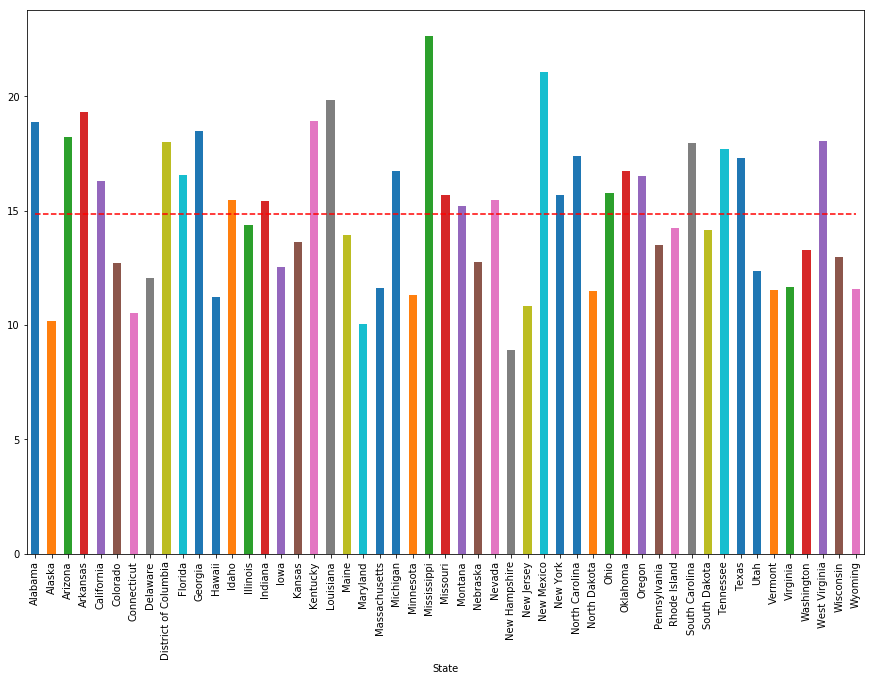

In [367]:
# Computation of Poverty by State
poverty_df = census_df[['State', 'County', 'TotalPop', 'Poverty']].copy()
poverty_df['Poverty_Amount'] = poverty_df.apply(lambda r: r['TotalPop'] * r['Poverty']/100, axis=1)

poverty_state_df = poverty_df.groupby('State').sum().reset_index()
poverty_state_df['Poverty'] = poverty_state_df.apply(lambda r: r['Poverty_Amount'] / r['TotalPop'] * 100, axis=1)
poverty_state_df.index = poverty_state_df['State']
poverty_state_df.drop(poverty_state_df[poverty_state_df.index == 'Puerto Rico'].index, axis=0, inplace=True)

# Análises

## Visualização do índice de pobeza por estado

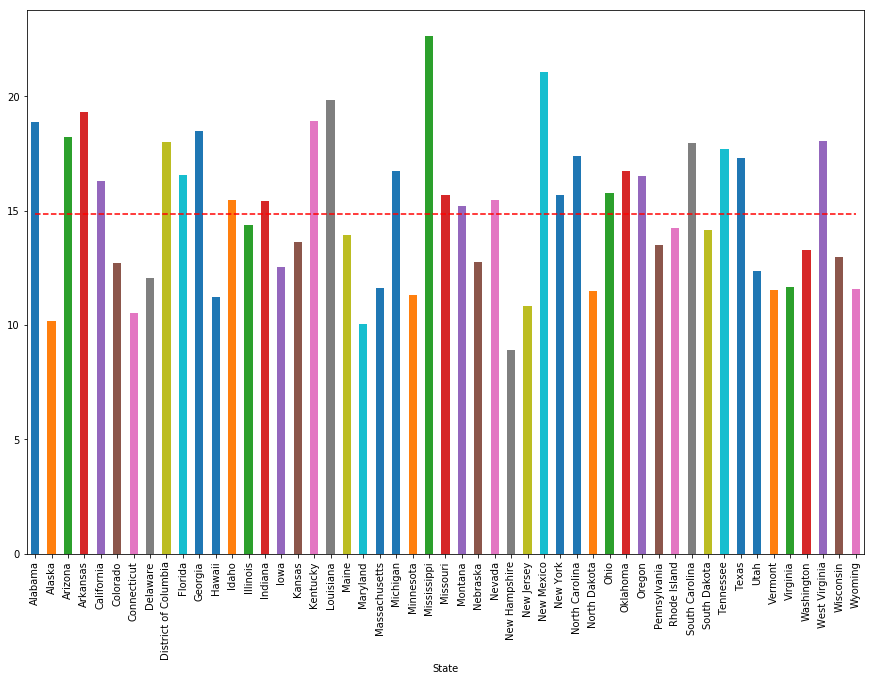

In [368]:
poverty_state_df['Poverty'].plot.bar(figsize=(15,10))
mean_poverty = poverty_state_df['Poverty'].mean()
plt.plot(poverty_state_df.index, [mean_poverty for i in range(len(poverty_state_df.index))], color='r', linestyle='--')

## Número de incidentes e mortes por estado

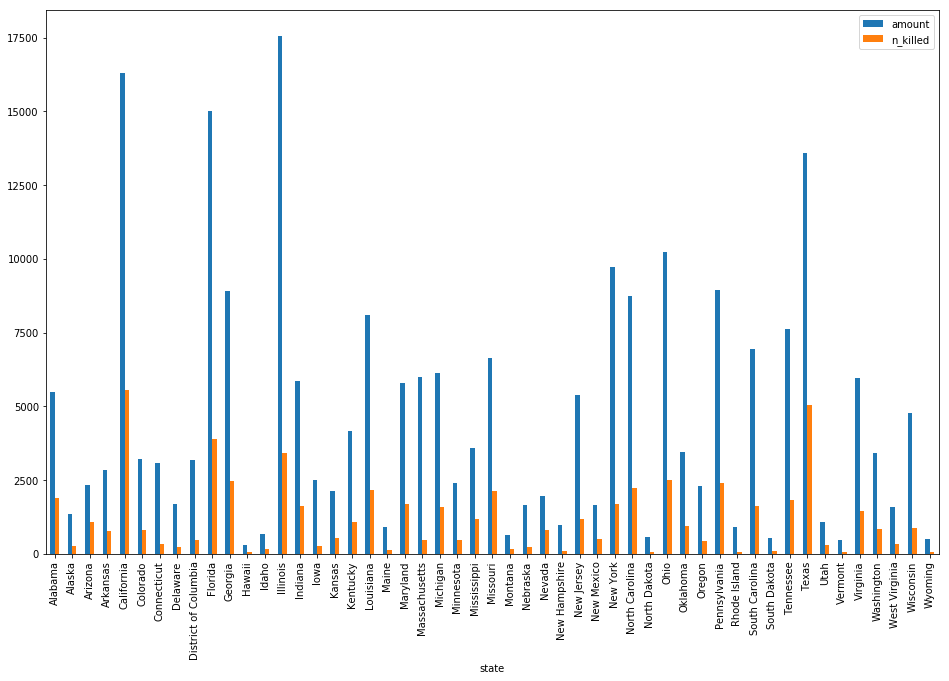

In [10]:
violence_state_group = gun_violence_df.loc[:, ['state', 'n_killed']].groupby('state')
violence_state_df = pd.DataFrame()
violence_state_df['amount'] = violence_state_group.size()
violence_state_df['n_killed'] = violence_state_group.sum()
violence_state_df.plot.bar(figsize=(16,10))

## Normalizando

Os números de incidentes e mortes estão sendo utilizados com os valores absolutos. Porém, estados com uma população maior vão tender a ter mais ocorrencias. Então, será criado atributos que levam em conta a população para computar a quantidade de incidentes e depois normalizar os dados.
Também será removido o Districto da Columbia, pois ele não está presente nas outras bases, por não ser um estado.

In [376]:
poputalion_df = poverty_state_df.loc[:, 'TotalPop'].copy()

violence_poverty_state = pd.concat([violence_state_df, poverty_state_df.loc[:,'Poverty'], poputalion_df], axis=1)
violence_poverty_state.drop('District of Columbia', axis=0, inplace=True)
violence_poverty_state['incidents_relative'] = violence_poverty_state.amount / violence_poverty_state.TotalPop
violence_poverty_state['killed_relative'] = violence_poverty_state.n_killed / violence_poverty_state.TotalPop
scaler = MinMaxScaler()
columns = violence_poverty_state.columns
index = violence_poverty_state.index
violence_poverty_state = pd.DataFrame(scaler.fit_transform(violence_poverty_state), columns=columns, index=index)
violence_poverty_state.head()

,amount,n_killed,Poverty,TotalPop,incidents_relative,killed_relative
Alabama,0.300110,0.331153,0.724380,0.112335,0.567380,0.807827
Alaska,0.061389,0.038147,0.091140,0.004062,1.000000,0.748918
Arizona,0.118087,0.188374,0.678689,0.160200,0.088741,0.281280
Arkansas,0.147854,0.130064,0.758867,0.062855,0.462204,0.507865
California,0.927608,1.000000,0.537868,1.000000,0.133967,0.234487
Colorado,0.168645,0.134242,0.276434,0.124181,0.245341,0.248622
Connecticut,0.160885,0.051589,0.115822,0.079635,0.396617,0.117526
Delaware,0.080848,0.029064,0.228187,0.009164,0.987345,0.444342
Florida,0.853651,0.699728,0.557571,0.503837,0.342422,0.361651
Georgia,0.500145,0.435786,0.697216,0.249117,0.420089,0.470636


## Visualização dos incidentes e mortes por estado (normalizados)

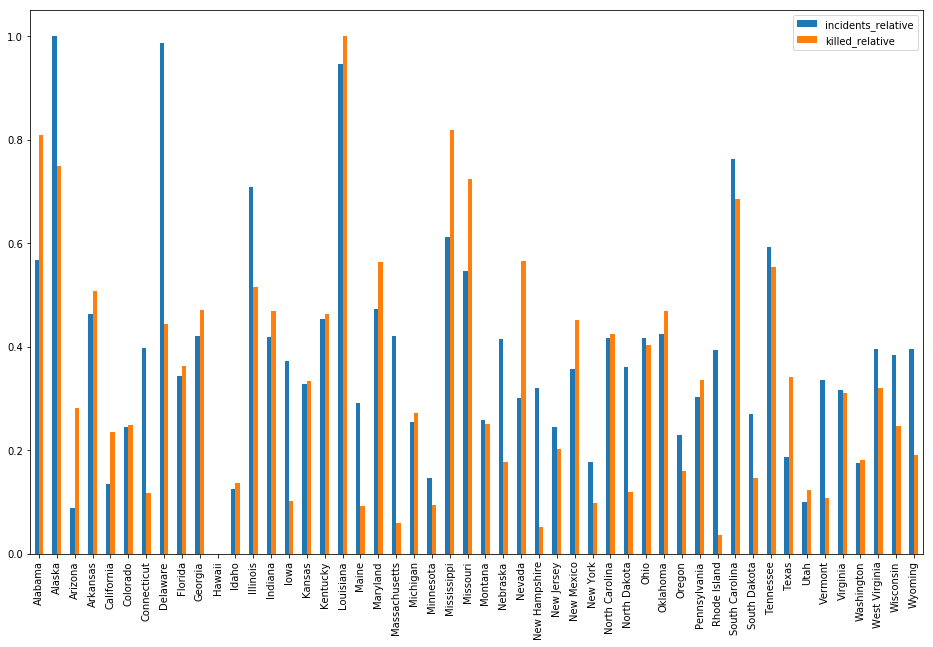

In [378]:
violence_poverty_state.loc[:,['incidents_relative', 'killed_relative']].plot.bar(figsize=(16,10))

## Correlação entre pobreza e violência com armas

Gráfico com incidentes/mortes de acordo com o índice de pobreza. 

,incidents_relative,killed_relative,Poverty
incidents_relative,1.000000,0.725088,0.152392
killed_relative,0.725088,1.000000,0.561863
Poverty,0.152392,0.561863,1.000000


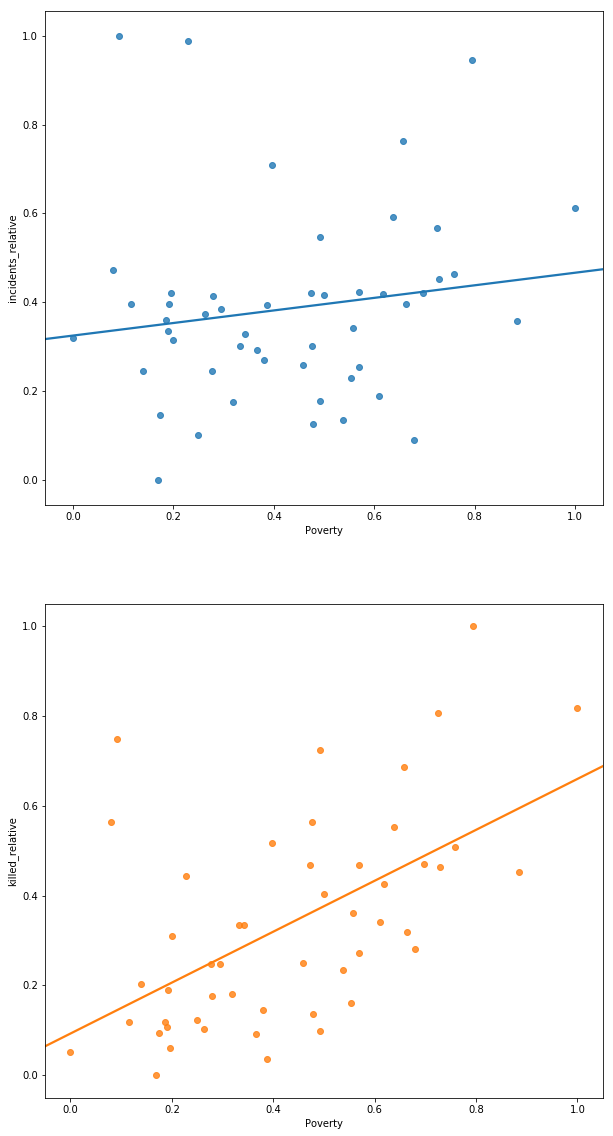

In [411]:
#violence_poverty_state_ordered = violence_poverty_state.sort_values(['Poverty'], ascending=True)
#violence_poverty_state_ordered.loc[:, ['Poverty', 'incidents_relative', 'killed_relative']].plot(subplots=False, x='Poverty',figsize=(12,12), grid=True)

fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(10,20))
sns.regplot(x='Poverty', y='incidents_relative', data=violence_poverty_state, ci=None, ax=axes[0])
sns.regplot(x='Poverty', y='killed_relative', data=violence_poverty_state, ci=None, ax=axes[1])

violence_poverty_state[['incidents_relative', 'killed_relative', 'Poverty']].corr()

## Cruzamento dos dados de violência com o de leis do porte de arma

In [470]:
firearm_2015 = firearm_law_df[firearm_law_df['year'] == 2015]
firearm_2015.index = firearm_2015.state

violence_poverty_firearm = pd.concat([violence_poverty_state, firearm_2015], axis=1)

In [473]:
scaler = MinMaxScaler()

violence_poverty_firearm['lawtotal'] = scaler.fit_transform(violence_poverty_firearm.lawtotal.values.reshape(-1,1))

print(violence_poverty_firearm[['Poverty', 'lawtotal']].corr())
violence_poverty_firearm.head()

           Poverty  lawtotal
Poverty   1.000000  0.333987
lawtotal  0.333987  1.000000


,amount,n_killed,Poverty,TotalPop,incidents_relative,killed_relative,state,year,age18longgunpossess,age18longgunsale,...,universal,universalh,universalpermit,universalpermith,violent,violenth,violentpartial,waiting,waitingh,lawtotal
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.300110,0.331153,0.724380,0.112335,0.567380,0.807827,Alabama,2015,1,1,...,1,1,1,1,1,1,1,1,1,0.938776
Alaska,0.061389,0.038147,0.091140,0.004062,1.000000,0.748918,Alaska,2015,1,0,...,1,1,1,1,1,1,1,1,1,1.000000
Arizona,0.118087,0.188374,0.678689,0.160200,0.088741,0.281280,Arizona,2015,0,1,...,1,1,1,1,1,1,1,1,1,0.928571
Arkansas,0.147854,0.130064,0.758867,0.062855,0.462204,0.507865,Arkansas,2015,1,1,...,1,1,1,1,1,1,1,1,1,0.928571
California,0.927608,1.000000,0.537868,1.000000,0.133967,0.234487,California,2015,1,0,...,0,0,0,0,0,0,0,0,0,0.000000


## Criação de features para cada categoria de lei

Para cada uma das 14 categorias das leis do porte de armas, será criado uma feature com a quantidade total de liberação no estado, ou seja, o somatório das leis pertencente aquele grupo.

In [476]:
law_by_category_df = pd.DataFrame()
for category in law_categories:
    law_by_category_df[category + '_total'] = firearm_2015.loc[:, law_categories[category]].sum(axis=1)
law_by_category_df['total'] = law_by_category_df.sum(axis=1)

violence_firearm_categories = pd.concat([violence_poverty_firearm[['killed_relative', 'incidents_relative', 'Poverty']], law_by_category_df], axis=1)
columns = violence_firearm_categories.columns
index = violence_firearm_categories.index 

scaler = MinMaxScaler()
violence_firearm_categories = pd.DataFrame(scaler.fit_transform(violence_firearm_categories), columns=columns, index=index)

print(violence_firearm_categories.corr()['killed_relative'])
violence_firearm_categories.head()

killed_relative                 1.000000
incidents_relative              0.725088
Poverty                         0.561863
dealer_total                    0.335286
buyer_total                     0.334714
prohibitions_high_risk_total    0.257047
background_check_total          0.316712
ammunition_total                0.246557
possesion_total                 0.150313
concealed_carry_total          -0.042320
assault_wrapons_total           0.209630
child_access_total              0.303934
grun_traffing_total             0.230330
stand_your_ground_total         0.442722
preemption_total                0.355914
immunity_total                  0.429920
domestic_violence_total         0.304441
total                           0.346308
Name: killed_relative, dtype: float64


,killed_relative,incidents_relative,Poverty,dealer_total,buyer_total,prohibitions_high_risk_total,background_check_total,ammunition_total,possesion_total,concealed_carry_total,assault_wrapons_total,child_access_total,grun_traffing_total,stand_your_ground_total,preemption_total,immunity_total,domestic_violence_total,total
state,,,,,,,,,,,,,,,,,,
Alabama,0.807827,0.567380,0.724380,0.928571,1.000000,0.666667,1.0,1.000000,1.000000,0.428571,1.000,1.000000,1.0,1.0,1.000000,1.0,0.888889,0.938776
Alaska,0.748918,1.000000,0.091140,1.000000,0.933333,0.888889,1.0,1.000000,0.888889,0.857143,1.000,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000
Arizona,0.281280,0.088741,0.678689,1.000000,1.000000,0.555556,1.0,1.000000,0.888889,0.571429,1.000,1.000000,1.0,1.0,1.000000,1.0,0.833333,0.928571
Arkansas,0.507865,0.462204,0.758867,1.000000,1.000000,0.666667,1.0,1.000000,0.777778,0.285714,1.000,1.000000,1.0,0.0,1.000000,1.0,1.000000,0.928571
California,0.234487,0.133967,0.537868,0.000000,0.266667,0.222222,0.0,0.333333,0.444444,0.142857,0.125,0.181818,0.0,0.0,0.333333,0.0,0.000000,0.000000


## Análise da relação entre número de permissões para portar armas e o número de mortes

                 killed_relative  lawtotal
killed_relative         1.000000  0.346308
lawtotal                0.346308  1.000000


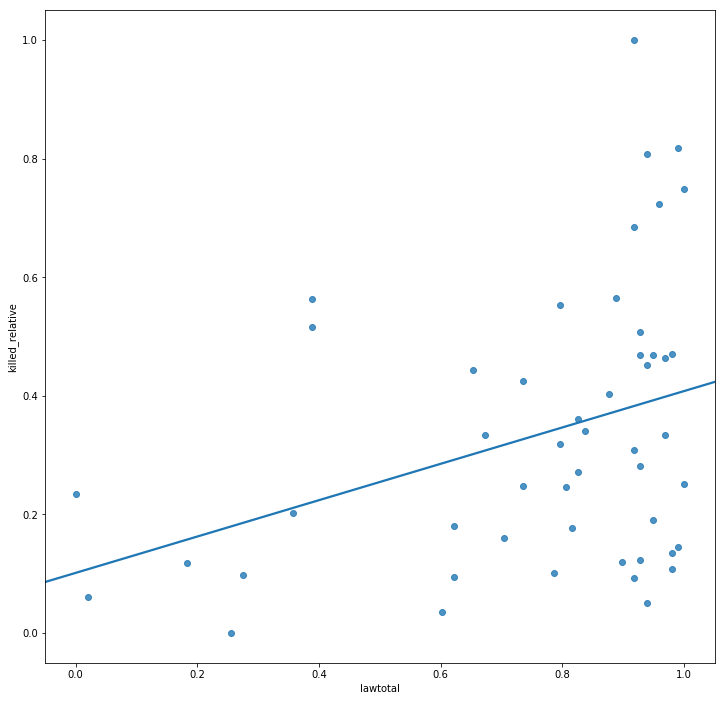

In [477]:
print(violence_poverty_firearm[['killed_relative', 'lawtotal']].corr())

fig, ax = plt.subplots(figsize=(12,12))
sns.regplot(x='lawtotal', y='killed_relative', data=violence_poverty_firearm, ci=None, ax=ax)

## Analisando alguns dados que não seguem pontualmente a reta

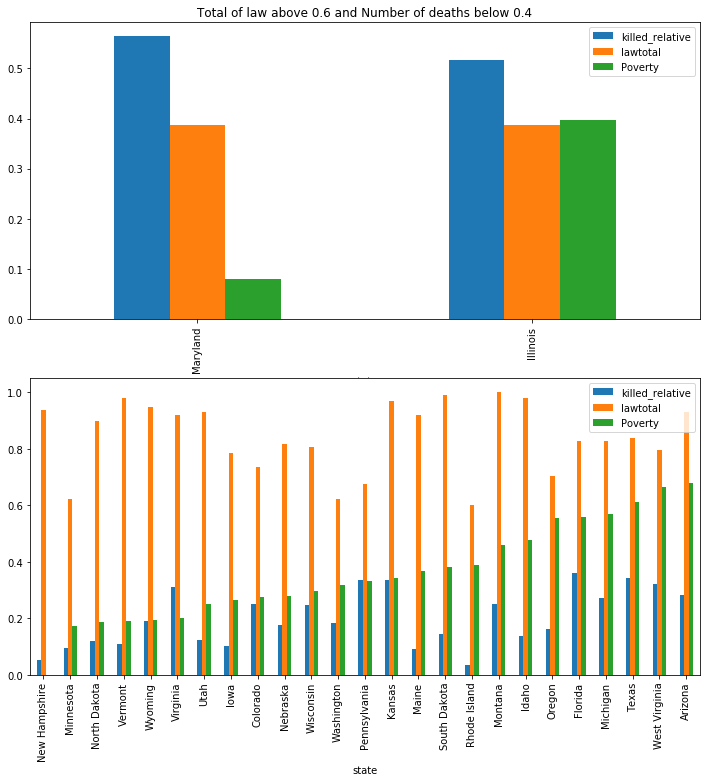

In [479]:
fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(10,20))
axes[0].set_title('Total of law below 0.5 and Number of deaths above 0.5')
axes[0].set_title('Total of law above 0.6 and Number of deaths below 0.4')
df_ordened = violence_poverty_firearm.sort_values('Poverty', ascending=True)
df_ordened[['killed_relative', 'lawtotal', 'Poverty']][(df_ordened['killed_relative'] > 0.5) & (df_ordened['lawtotal'] < 0.5)].plot.bar(figsize=(12,12), ax=axes[0])
df_ordened[['killed_relative', 'lawtotal', 'Poverty']][(df_ordened['killed_relative'] < 0.4) & (df_ordened['lawtotal'] > 0.6)].plot.bar(figsize=(12,12), ax=axes[1])


## Correlação entre as features (Leis, Incidentes, Pobreza) e o Número de Mortos

In [480]:
death_correlation = violence_poverty_firearm.corr().drop(['amount', 'n_killed', 'killed_relative', 'year'], axis=0).loc[:,'killed_relative'].sort_values(ascending=False)
death_correlation

incidents_relative           0.725088
Poverty                      0.561863
nosyg                        0.442722
immunity                     0.429920
mcdvdating                   0.376514
preemptionnarrow             0.364521
age21handgunpossess          0.356129
universalpermit              0.351301
violentpartial               0.347762
statechecks                  0.347007
preemption                   0.346495
lawtotal                     0.346308
universalpermith             0.338490
permith                      0.326638
dealer                       0.325160
statechecksh                 0.324225
reportall                    0.319371
purge                        0.318218
age21handgunsale             0.317897
permitlaw                    0.314879
alctreatment                 0.309113
mcdvsurrenderdating          0.307077
security                     0.304525
preemptionbroad              0.302636
permit                       0.295846
cap14                        0.293506
capuses     

In [536]:
high_correlation_features = death_correlation[2:27].index.values

## Classificação

Agora será realizado um processo de classificação para predizer o nível de mortes em um estado, considerando as features de pobreza e as leis para o porte de armas em um estado.

In [350]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_test)
print(y_pred)
print(accuracy_score(y_test, y_pred))

model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(scores)
scores.mean()

1     2
15    1
16    1
33    0
35    1
38    0
40    0
43    0
49    0
Name: death_rate, dtype: category
Categories (3, int64): [0, 1, 2]
[0 0 1 0 1 0 2 0 0]
0.6666666666666666
[0.58333333 0.72727273 0.66666667 0.55555556 0.44444444]


0.5954545454545455

## Criação do target

Vamos ter três categorias: L, M e H, que representam Low, Medium e High, respectivamente. São meta dados que representam as faixas: 0 < 0.33 < 0.66 <= 1

In [491]:
violence_firearm_categories['death_rate'] = violence_firearm_categories.apply(lambda r: 'L'if r['killed_relative'] < 0.33 else 'M' if r['killed_relative'] < 0.66 else 'H', axis=1)
violence_firearm_categories['death_rate'] = violence_firearm_categories.death_rate.astype('category')
violence_firearm_categories['death_rate'].head()

state
Alabama       H
Alaska        H
Arizona       L
Arkansas      M
California    L
Name: death_rate, dtype: category
Categories (3, object): [H, L, M]

## Separação dos dados em Features e Target

As features utilizadas são a sumarização das leis por categoria e as leis selecionadas com maior correlação com número de mortos por estado.

In [540]:
X = violence_firearm_categories.drop(['death_rate', 'killed_relative', 'incidents_relative', 'total'], axis=1)
X = pd.concat([X, violence_poverty_firearm.loc[:, high_correlation_features]], axis=1)
y = violence_firearm_categories['death_rate'].copy()

X.head()

,Poverty,dealer_total,buyer_total,prohibitions_high_risk_total,background_check_total,ammunition_total,possesion_total,concealed_carry_total,assault_wrapons_total,child_access_total,...,purge,age21handgunsale,permitlaw,alctreatment,mcdvsurrenderdating,security,preemptionbroad,permit,cap14,capuses
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.724380,0.928571,1.000000,0.666667,1.0,1.000000,1.000000,0.428571,1.000,1.000000,...,1,1,1,1,1,1,1,1,1,1
Alaska,0.091140,1.000000,0.933333,0.888889,1.0,1.000000,0.888889,0.857143,1.000,1.000000,...,1,1,1,1,1,1,1,1,1,1
Arizona,0.678689,1.000000,1.000000,0.555556,1.0,1.000000,0.888889,0.571429,1.000,1.000000,...,1,1,1,1,1,1,1,1,1,1
Arkansas,0.758867,1.000000,1.000000,0.666667,1.0,1.000000,0.777778,0.285714,1.000,1.000000,...,1,1,1,1,1,1,1,1,1,1
California,0.537868,0.000000,0.266667,0.222222,0.0,0.333333,0.444444,0.142857,0.125,0.181818,...,0,0,1,1,0,0,0,0,0,0


## Cross Validation e Oversampling

Como existem poucos dados (estados), será utilizado cross validation para poder ter mais possibilidades no teste.
Outro problema nos dados é o desbalanceamento. Onde a classe majoritária é a do nível baixo de mortes. Então, aplicaremos SMOTE para aumentar os dados de treinamento das classes minoritárias.

In [545]:
scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train, y_train = SMOTE(k_neighbors=3).fit_sample(X_train, y_train)
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

print("Accuracy: {0:.2f}%".format(np.array(scores).mean() * 100))

Accuracy: 55.05%


# Conclusão

Apesar da acurácia não ter sido alta, ainda assim é maior que um valor aleatório (33.3%, por serem três classes). O que comprova o fato das leis e índice de pobreza interferirem no percentual de mortes envolvendo armas, como os gráficos e correlação mostraram anteriormente. Porém, esse não são os únicos fatores para determinar esse número.